# 課題２
私が茶道部に所属していることを所以に、抹茶を話題にした。
茶道の世界においては抹茶を点てることに意味があるが、その立て方は流派によって違いがある。例えば表千家で泡をあまり立てずに点てるが、裏千家ではしっかりとクリーミーな泡を成型する。

(なお旧東工大は裏千家である)

今回は代表的な流派である表千家と裏千家の立て方を深層学習によって分類するモデルを作成した。
なお使用するデータは自前で用意したものをgithub上にアップロードして引っ張ってきている。

Cloning into 'prototype'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 70 (delta 7), reused 2 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (70/70), 15.09 MiB | 19.34 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 84.4MB/s]


Epoch 1/15 | Train Loss: 0.762 | Train Acc: 0.316 | Val Loss: 0.667 | Val Acc: 0.600
Epoch 2/15 | Train Loss: 0.419 | Train Acc: 0.842 | Val Loss: 0.916 | Val Acc: 0.200
Epoch 3/15 | Train Loss: 0.382 | Train Acc: 0.895 | Val Loss: 1.058 | Val Acc: 0.200
Epoch 4/15 | Train Loss: 0.367 | Train Acc: 0.895 | Val Loss: 0.861 | Val Acc: 0.200
Epoch 5/15 | Train Loss: 0.123 | Train Acc: 1.000 | Val Loss: 0.845 | Val Acc: 0.400
Epoch 6/15 | Train Loss: 0.088 | Train Acc: 1.000 | Val Loss: 0.809 | Val Acc: 0.200
Epoch 7/15 | Train Loss: 0.104 | Train Acc: 1.000 | Val Loss: 0.556 | Val Acc: 1.000
Epoch 8/15 | Train Loss: 0.319 | Train Acc: 0.947 | Val Loss: 0.812 | Val Acc: 0.400
Epoch 9/15 | Train Loss: 0.050 | Train Acc: 1.000 | Val Loss: 0.349 | Val Acc: 1.000
Epoch 10/15 | Train Loss: 0.042 | Train Acc: 1.000 | Val Loss: 0.436 | Val Acc: 0.800
Epoch 11/15 | Train Loss: 0.250 | Train Acc: 0.947 | Val Loss: 0.365 | Val Acc: 0.800
Epoch 12/15 | Train Loss: 0.145 | Train Acc: 1.000 | Val Loss: 

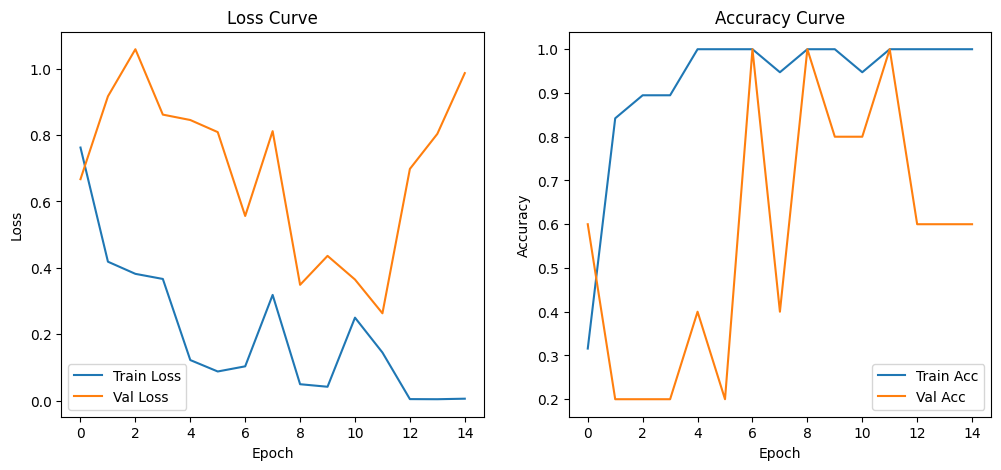

In [1]:
#薄茶流派判別モデル

!git clone https://github.com/natsu831/prototype.git   #個人のgithubへlink

import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

# ファイル作成
os.makedirs('/content/data/omote', exist_ok=True)
os.makedirs('/content/data/ura', exist_ok=True)

# omote フォルダの画像をコピー
for f in os.listdir('/content/prototype/omote'):
    if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
        shutil.copy(os.path.join('/content/prototype/omote', f), '/content/data/omote')
# ura フォルダの画像をコピー
for f in os.listdir('/content/prototype/ura'):
    if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
        shutil.copy(os.path.join('/content/prototype/ura', f), '/content/data/ura')


# 前処理・拡張
# →用意した画像が計24枚しかないため
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

val_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])


# データセットロード
full_dataset = datasets.ImageFolder(root='/content/data', transform=train_transforms)

# 少量なので80訓練/20教師で分割
train_size = int(0.8 * len(full_dataset))
val_size   = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)



# モデル定義
model = models.mobilenet_v3_small(weights='IMAGENET1K_V1')#IMAGENET1K_V1使用
num_features = model.classifier[3].in_features
model.classifier[3] = nn.Linear(num_features, 2)  # 表千家 or 裏千家

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


# 損失関数
criterion = nn.CrossEntropyLoss()        #クロスエントロピー損失を採用
optimizer = optim.Adam(model.parameters(), lr=0.0005)


# 学習
epochs = 15
train_losses, val_losses = [], []    #学習過程グラフ用
train_accs, val_accs = [], []


for epoch in range(epochs):
    # 訓練
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)           #順伝播
        loss = criterion(outputs, labels) #損失計算
        loss.backward()                   #逆伝播
        optimizer.step()                  #結果反映

        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc  = correct / total

    # 検証
    model.eval()
    val_loss_total, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss_total += loss.item()

            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_loss_total / len(val_loader)
    val_acc  = val_correct / val_total

    #記録
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.3f} | Val Loss: {val_loss:.3f} | Val Acc: {val_acc:.3f}")




# 学習曲線描画
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# モデルの試用

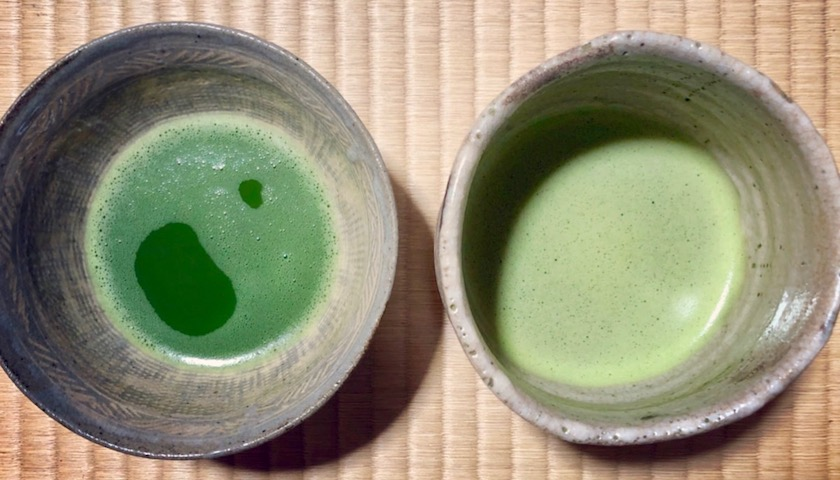



**学習に用いてない画像(左：表千家、右：裏千家)で検証**



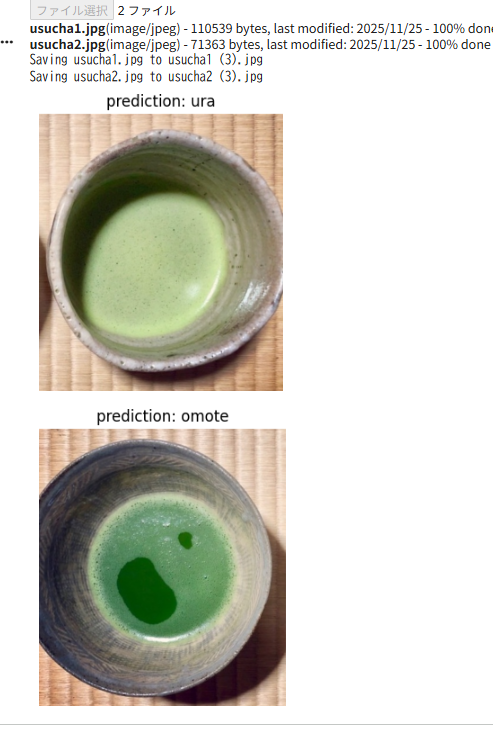

成功した。

Saving usucha1.jpg to usucha1.jpg
Saving usucha2.jpg to usucha2.jpg


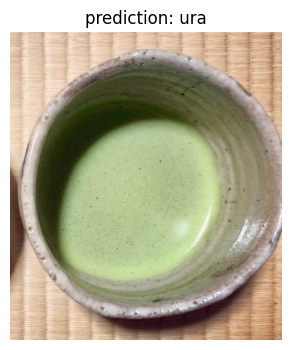

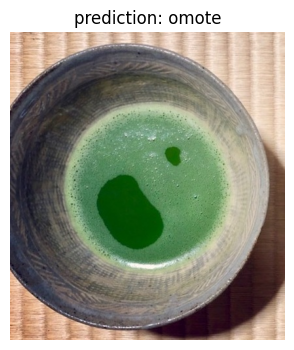

In [2]:
from google.colab import files
from PIL import Image
from torchvision import transforms
import torch
import matplotlib.pyplot as plt

# クラスラベル
classes = ['omote', 'ura']

# 画像前処理
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

# 画像アップロード
uploaded = files.upload()

for filename in uploaded.keys():
    # 画像読み込み
    img = Image.open(filename).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)

    # 推論
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        pred = output.argmax(dim=1).item()

    # 画像と結果表示
    plt.figure(figsize=(4,4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'prediction: {classes[pred]}')
    plt.show()
